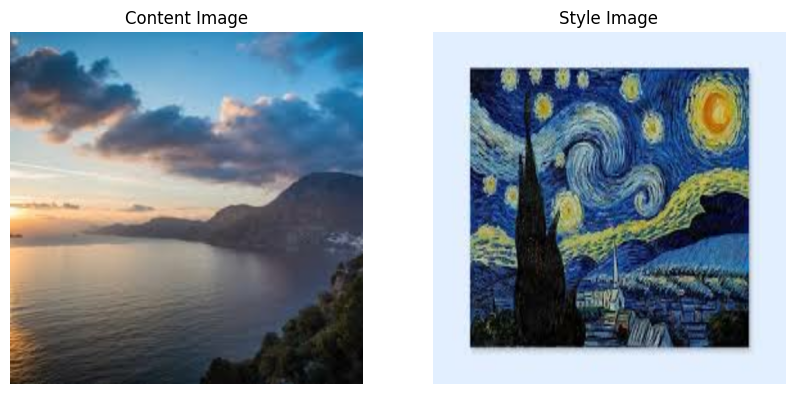

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load images
content_image = tf.io.read_file('content_image.jpg')
content_image = tf.image.decode_image(content_image, channels=3)
content_image = tf.image.resize(content_image, (512, 512))
content_image = content_image / 255.0

style_image = tf.io.read_file('style_image.jpg')
style_image = tf.image.decode_image(style_image, channels=3)
style_image = tf.image.resize(style_image, (512, 512))
style_image = style_image / 255.0

# Display images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Content Image")
plt.imshow(content_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Style Image")
plt.imshow(style_image)
plt.axis('off')

plt.show()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [4]:
# Load pre-trained VGG19 model
vgg = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet'
)

# Freeze model layers
vgg.trainable = False

print("VGG19 model loaded successfully")

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG19 model loaded successfully


In [5]:
# Define content and style layers
content_layers = ['block5_conv2']

style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

print("Content layers:", content_layers)
print("Style layers:", style_layers)

Content layers: ['block5_conv2']
Style layers: ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']


In [6]:
# Build a model that returns content and style features
def vgg_layers(layer_names):
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

# Create models for style and content
style_extractor = vgg_layers(style_layers)
content_extractor = vgg_layers(content_layers)

print("Feature extraction models created")

Feature extraction models created


In [7]:
# Add batch dimension to images
content_image = tf.expand_dims(content_image, axis=0)
style_image = tf.expand_dims(style_image, axis=0)

print("Batch dimension added")


Batch dimension added


In [8]:
# Define Gram Matrix function
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

print("Gram matrix function defined")


Gram matrix function defined


In [9]:
# Extract style features
style_features = style_extractor(style_image * 255)
style_features = [gram_matrix(feature) for feature in style_features]

# Extract content features
content_features = content_extractor(content_image * 255)

print("Content and style features extracted successfully")


Content and style features extracted successfully


In [10]:
# Style loss
def style_loss(style_outputs, style_targets):
    loss = tf.add_n([
        tf.reduce_mean((style_outputs[i] - style_targets[i])**2)
        for i in range(len(style_outputs))
    ])
    return loss

# Content loss
def content_loss(content_outputs, content_targets):
    return tf.reduce_mean((content_outputs[0] - content_targets[0])**2)

print("Style and content loss functions defined")


Style and content loss functions defined


In [11]:
# Initialize generated image (start from content image)
generated_image = tf.Variable(content_image, dtype=tf.float32)

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)

print("Generated image and optimizer initialized")



Generated image and optimizer initialized


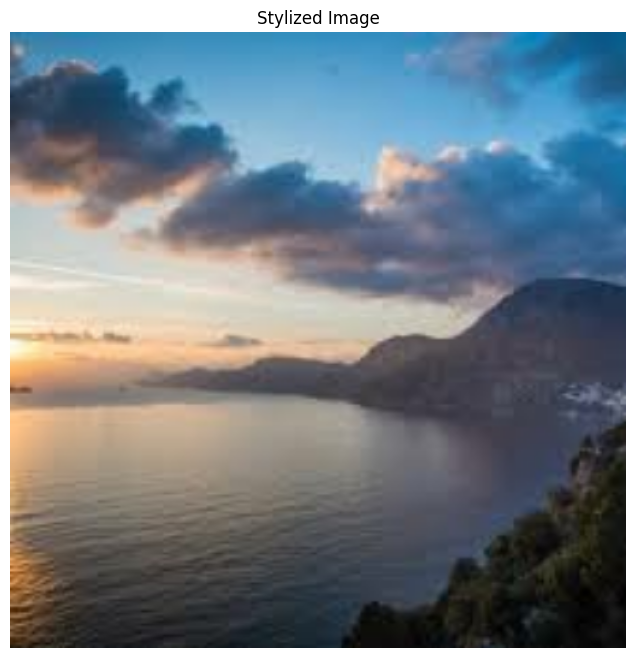

Stylized image displayed and saved successfully 💗


In [12]:
import matplotlib.pyplot as plt

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = tf.cast(tensor, tf.uint8)
    return tensor[0]

# Display final stylized image
plt.figure(figsize=(8, 8))
plt.imshow(tensor_to_image(generated_image))
plt.axis('off')
plt.title("Stylized Image")
plt.show()

# Save the image
output_image = tensor_to_image(generated_image)
tf.keras.utils.save_img("stylized_output.jpg", output_image)

print("Stylized image displayed and saved successfully 💗")


In [ ]:
# Total loss weights
style_weight = 1e-2
content_weight = 1e4

@tf.function
def train_step(image):
    with tf.GradientTape() as tape:
        # Extract features from generated image
        style_outputs = style_extractor(image * 255)
        style_outputs = [gram_matrix(feature) for feature in style_outputs]

        content_outputs = content_extractor(image * 255)

        # Compute losses
        s_loss = style_loss(style_outputs, style_features)
        c_loss = content_loss(content_outputs, content_features)

        total_loss = style_weight * s_loss + content_weight * c_loss

    grads = tape.gradient(total_loss, image)
    optimizer.apply_gradients([(grads, image)])
    image.assign(tf.clip_by_value(image, 0.0, 1.0))

    return total_loss

# Run optimization loop (keep small for demo)
epochs = 5

for i in range(epochs):
    loss = train_step(generated_image)
    print(f"Epoch {i+1}/{epochs}, Loss: {loss.numpy()}")
